In [1]:
from FEnicS_base import *
from Parametrs import *
from Task_factories import * 
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np
import ufl
import matplotlib.pyplot as plt

import jsonpickle as jp
import shutil
import re
from tqdm import tqdm


class ArrayFunc:

    def __init__(self, func: fem.Function, name=None):
        self.cord = np.array([
            func.function_space.tabulate_dof_coordinates()[:, 0],
            func.x.array,
        ])
        self._sort()
        self.cord = np.array([[a, b]for a, b in enumerate(self.cord[1])]).transpose() #yapf: disable
        self.len = len(self.cord[0])
        self.name = name

    def _sort(self):
        self.cord = self.cord[:, np.argsort(self.cord[0])]

    def translate(self, point_0):
        x_new = (self.cord[0] - point_0)
        self.cord[0] = x_new - self.len * (x_new // (self.len))
        self._sort()

    def mirror(self, point_0):
        self.translate(point_0)
        self.cord[0] = -self.cord[0]
        self.cord[0] += self.len
        self._sort()


def function_plots(
    functions,
    fig=None,
    ax=None,
    show_points=False,
):
    """Create plot from fem.Function
    
    Args:
        fig (plt.Figure): Figure
        lists (fem.Function, str): List of (u, title)
        points_on (bool): If true create scatter
    """
    if (fig or ax) is None:
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(16, 8)
    for func in functions:
        x = func.function_space.tabulate_dof_coordinates()[:, 0]
        y = func.x.array
        cord = np.array([x, y])
        cord = cord[:, np.argsort(cord[0])]
        ax.plot(cord[0], cord[1], label=func.name, linewidth=1)
        if show_points: ax.scatter(cord[0], cord[1], s=0.5)
    ax.legend(
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0,
        loc='center left',
    )
    return ax


def clear_savedir(path_save):
    """Clear directory in VTK folder"""

    try:
        shutil.rmtree(path_save)
    except:
        pass


def view_file1D(
    name,
    dir='/home/VTK/System1D_files/',
    view_dir='/home/VTK/System1D_files/0',
):
    shutil.copytree(dir + name, view_dir, dirs_exist_ok=True)


def repr_str(func, pars: list = {}) -> str:
    # TODO: to module
    # FIXME: (( to (\n(
    rep = str(func)
    rep = re.sub(r'\{ A \| A_\{i_(\d|\{\d+\})\} \=', '', rep)
    rep = re.sub(r'\[i_(\d|{\d+})]', '', rep)
    rep = re.sub(r'dx.+\)', 'dx', rep)
    rep = re.sub(r'ds.+\)', 'ds', rep)
    for key, value in pars.items():
        rep = rep.replace(key, value)

    base = {
        'v_0[0]': 'v',
        'v_0[1]': 'u',
        '-1 * ': '-',
        '+ -': '-',
        'f[0]': 'N',
        'f[1]': 'P',
        '{': '{\n',
        '} *': '\n} *',
    }
    for key, value in base.items():
        rep = rep.replace(key, value)

    beauty = {
        '(grad(P))': 'grad(P)',
        '(grad(N))': 'grad(N)',
        '(grad(u))': 'grad(u)',
        '(grad(v))': 'grad(v)',
        '})': ')',
        '+ (': '\n   +(',
    }
    for key, value in beauty.items():
        rep = rep.replace(key, value)
    return rep


class Param_dump(Param_INTERFACE):

    def __init__(
        self,
        A_NM=None,
        B_PM=None,
        E_NP=None,
        LIHGT=None,
        REACTION=None,
        EQUATION_N=None,
        EQUATION_P=None,
    ):
        self.A_NM = repr_str(A_NM)
        self.B_PM = repr_str(B_PM)
        self.E_NP = repr_str(E_NP)
        self.LIHGT = repr_str(LIHGT)
        self.REACTION = repr_str(REACTION)

        replace = {
            str(A_NM): 'A_NM',
            str(B_PM): 'B_PM',
            str(E_NP): 'E_NP',
            str(LIHGT): 'light',
            str(REACTION): 'REACTION'
        }
        self.EQUATION_N = repr_str(EQUATION_N, replace)
        self.EQUATION_P = repr_str(EQUATION_P, replace)


In [2]:
# Set up parametrs
consts = Param_const(
    gen_rate=0.01,
    a_rate=1,
    b_rate=0.1,
    e_rate=0.5,
    P_step=0.13,
)
sol = Param_solve_confs(
    solve_options={
        'convergence': 'incremental', 'tolerance': 1E-6
    }
)

DATA = Param_DATA(
    # solve_confs=sol,
    # save=Param_save(save_name='input', desc='input'),
    # bcs=Param_bcs(
    #     bcs_kind='like_inside',
    #     N_pars={'N_ext': 0.2, 'P_ext': 0.001},
    #     P_pars={'N_ext': 0.2, 'P_ext': 0.001},
    # ),
    time=Param_time(dt=0.001, ),
    consts=consts,
    light=Param_light(kind='sigmoid', left=0.1, right=0.2, slope=20),
    mesh=Param_mesh(domain_intervals=100, degree=1),
)


In [3]:
# Task
def solve(
    n_steps=DATA.time.n_steps,
    reset=True,
    save=False,
    save_confs={
        'sqn': False, 'sqp': False
    }
):

    def _set_next():
        # TODO: interpolate bcs
        FUNC0.interpolate(FUNC)
        TIME.value += DATA.time.dt

    def _solve_default(steps):
        for step in steps:
            _set_next()
            steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
            PROBLEM.solve()

    def _solve_with_save(steps, data_save: Param_save = DATA.save):

        def _save_functions(file, time):
            file.write_function(SUB_FUNC.N, time)
            file.write_function(SUB_FUNC.P, time)
            light = Function(SUBSPACE.N, LIHGT)
            light.name = 'Light'

            if save_confs['sqn']:
                flux_N = Function(SUBSPACE.N, SURFACE.N)
                flux_N.name = 'flux_N'
                file.write_function(flux_N, time)
            if save_confs['sqp']:
                flux_P = Function(SUBSPACE.P, SURFACE.P)
                flux_P.name = 'flux_P'
                file.write_function(flux_P, time)

        clear_savedir(data_save.dir_save + data_save.save_name)
        save_path = data_save.dir_save + data_save.save_name + data_save.file_name
        check_every = int(DATA.time.n_steps / DATA.time.n_shecks)

        SUB_FUNC.N.name = 'neutral'
        SUB_FUNC.P.name = 'polimer'
        with io.XDMFFile(DOMAIN.comm, save_path + '.xdmf', 'w') as file:
            file.write_mesh(DOMAIN)
            for step in steps:
                if step % check_every == 0:
                    steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
                    _save_functions(file, TIME.value)
                _set_next()
                PROBLEM.solve()
            _save_functions(file, TIME.value)
        dump(True)

    if reset: set_initial()
    steps_line = tqdm(
        desc=f'Solving PDE. Time:{TIME.value:.3f}',
        iterable=np.arange(0, n_steps, dtype=int),
    )
    if save: _solve_with_save(steps_line, data_save=DATA.save)
    else: _solve_default(steps_line)


def draw(
    show_f={
        'sqn': False, 'sqp': False
    }, flux_scale=100, show_points=False
):
    light_col = Function(SUBSPACE.N, LIHGT, 'Light')
    N_col = Function(SUBSPACE.N, SUB_FUNC.N, 'Neutral')
    P_col = Function(SUBSPACE.N, SUB_FUNC.P, 'Polimer')
    M_col = Function(SUBSPACE.N, 1 - N_col - P_col, 'Monomer')
    SQN_col = Function(SUBSPACE.N, flux_scale * SURFACE.N, 'flux_N')
    SQP_col = Function(SUBSPACE.N, flux_scale * SURFACE.P, 'flux_P')
    collection = [N_col, light_col, M_col, P_col]
    if show_f['sqn']: collection.append(SQN_col)
    if show_f['sqp']: collection.append(SQP_col)
    function_plots(functions=collection, show_points=show_points)


def check_symmetry(
    func: fem.Function,
    add_point=0,
    data=DATA,
):
    from matplotlib.ticker import FormatStrFormatter

    def find_middle(add_point):
        middle_x = (data.light.left + data.light.right) / 2
        middle_point = int((data.mesh.left + middle_x) /
                           (data.mesh.right - data.mesh.left) * base.len)
        middle_point += add_point
        return middle_point

    def plot(func: ArrayFunc):
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(20, 10)
        ax.grid(True, which='Both')
        ax.set_xlim((min(func.cord[0]), max(func.cord[0])))
        ax.set_ylim((min(func.cord[1]), max(func.cord[1])))
        ax.yaxis.set_major_formatter(FormatStrFormatter(('%.3f')))
        plt.plot([middle, middle], (min(func.cord[1]), max(func.cord[1])),
                 c='red')

        ax.plot(func.cord[0], func.cord[1], label=func.name, color='black')
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] > func.cord[1] * 0,
            alpha=0.5,
            facecolor='green',
            label=func.name,
        )
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] < func.cord[1] * 0,
            alpha=0.5,
            facecolor='red',
            label=func.name,
        )

    print('Rule: Right - left')
    base = ArrayFunc(Function(func.function_space, func), 'base')
    dif = ArrayFunc(Function(func.function_space, func), 'dif')
    middle = find_middle(add_point)

    dif.mirror(middle)
    dif.translate(-middle)
    dif.cord[1] = (dif.cord[1] - base.cord[1]) / base.cord[1]
    dif.cord[1, dif.cord[0] >= middle] = 0
    plot(dif)
    plot(base)


def dump(save=False):
    replace = {
        str(CONST.A_NM): 'A_NM',
        str(CONST.B_PM): 'B_PM',
        str(CONST.E_NP): 'E_NP',
        str(LIHGT): 'light',
        str(CONST.REACTION): 'REACTION',
    }
    DATA.dump = Param_dump(
        A_NM=CONST.A_NM,
        B_PM=CONST.B_PM,
        E_NP=CONST.E_NP,
        LIHGT=LIHGT,
        REACTION=CONST.REACTION,
        EQUATION_N=repr_str(EQUATION.N, replace),
        EQUATION_P=repr_str(EQUATION.P, replace)
    )
    if not save:
        print(DATA.dump.EQUATION_N)
        print('*' * 80)
        print(DATA.dump.EQUATION_P)
    else:
        with open(
            DATA.save.dir_save + DATA.save.save_name + DATA.save.file_name +
            '_anotaton.txt',
            'w',
        ) as annotation:
            annotation.write(jp.encode(DATA, numeric_keys=True, indent=4))


def set_initial(
    data: Param_initial = DATA.initial,
    confs=DATA.solve_confs,
):
    # TODO: reset bcs
    # TODO reset in comps
    SUB_FUNC.N.interpolate(Function(SUBSPACE.N, data.N0))
    SUB_FUNC.P.interpolate(Function(SUBSPACE.P, data.P0))

    FUNC.x.scatter_forward()
    FUNC0.interpolate(FUNC)

    TIME.value = 0
    global PROBLEM
    PROBLEM = NonlinearProblem(
        F=sum(EQUATION.values()),
        bcs=BCS,
        u=FUNC,
        solve_options=confs.solve_options,
        petsc_options=confs.petsc_options,
        form_compiler_params=confs.form_compiler_params,
        jit_params=confs.jit_params,
    )


# Components
def create_dirichlet():
    BCS1 = Function(SUBSPACE.N, 2 * X[0])
    bcs = [
        DirichletBC(
            space=BCS1.function_space,
            combined_marker=lambda x: np.isclose(x[0], 0),
            form=BCS1,
        )
    ]
    return []


def create_equation():

    def create_facets():
        set_connectivity(DOMAIN)
        ds = Measure("ds", domain=DOMAIN)
        return ds

    def inside_flux(
        a_NM=CONST.A_NM,
        b_PM=CONST.B_PM,
        e_NP=CONST.E_NP,
    ):
        flux_N = 0
        flux_N += -a_NM * grad(n)
        flux_N += +a_NM * p * grad(n)
        flux_N += -e_NP * p * grad(n)
        flux_N += -a_NM * n * grad(p)
        flux_N += +e_NP * n * grad(p)

        flux_P = 0
        flux_P += -b_PM * grad(p)
        flux_P += +b_PM * n * grad(p)
        flux_P += -e_NP * n * grad(p)
        flux_P += -b_PM * p * grad(n)
        flux_P += +e_NP * p * grad(n)
        return flux_N, flux_P

    dx = Measure('cell', subdomain_id='everywhere')
    dt = DATA.time.dt
    ds = create_facets()

    u, v = TestFunctions(SPACE)
    n, p = INDIC.N, INDIC.P
    n0, p0 = INDIC_0.N, INDIC_0.P
    qN, qP = inside_flux()

    equationN = (1/dt) * (n-n0) * u * dx
    equationN += -(qN|inner|grad(u)) * dx
    equationN += u * SURFACE.N * ds

    equationP = (1/dt) * (p-p0) * v * dx
    equationP += -(qP|dot|grad(v)) * dx
    equationP += -LIHGT * CONST.REACTION * v * dx
    equationP += v * SURFACE.P * ds

    return {'N': equationN, 'P': equationP}


DOMAIN = mesh.create_interval(
    nx=DATA.mesh.domain_intervals,
    comm=MPI.COMM_WORLD,
    points=[DATA.mesh.left, DATA.mesh.right],
)
SPACE = FunctionSpace(
    mesh=DOMAIN, element=Comp_Element(data=DATA.mesh, domain=DOMAIN).mix()
)
SUBSPACE = Comp_Sub_spaces(SPACE)
X = SpatialCoordinate(SPACE)

FUNC, FUNC0 = Function(SPACE), Function(SPACE)
SUB_FUNC = Comp_Sub_functions(FUNC)
INDIC = Comp_Indicators(FUNC)
INDIC_0 = Comp_Indicators(FUNC0)

TIME = Constant(SUBSPACE.N, 0)
LIHGT = Task_light(x=X[0], data=DATA.light)
CONST = Task_Consts(indic=INDIC, data=DATA.consts)
SURFACE = Comp_bcs(indic=INDIC, const=CONST, data=DATA.bcs, data_mesh=DATA.mesh)
BCS = create_dirichlet()

EQUATION = create_equation()
# FIXME: clear reset KSP solver
PROBLEM = []
set_initial()

Solving PDE. Time:1.00: 100%|██████████| 1000/1000 [00:06<00:00, 147.99it/s]


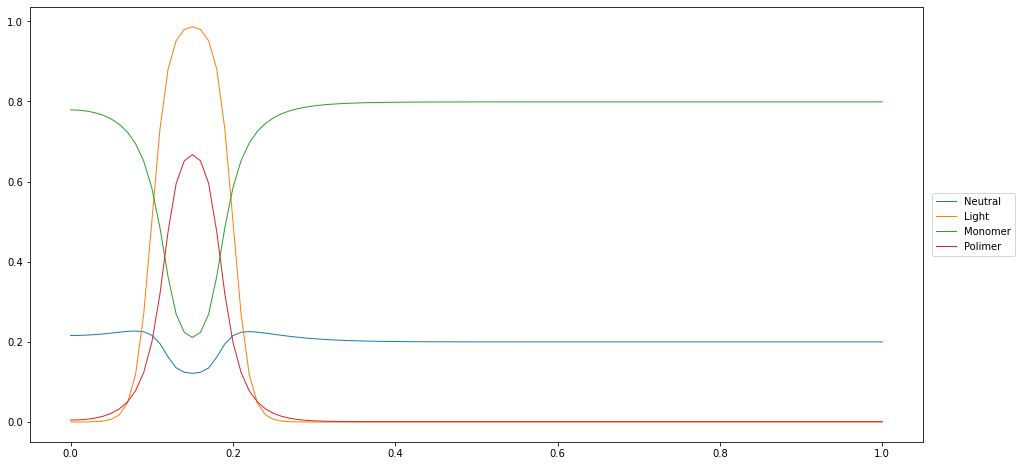

In [4]:
solve(
     # save=True,
     # n_steps=2000,
    reset=True,
)
draw()

Rule: Right - left


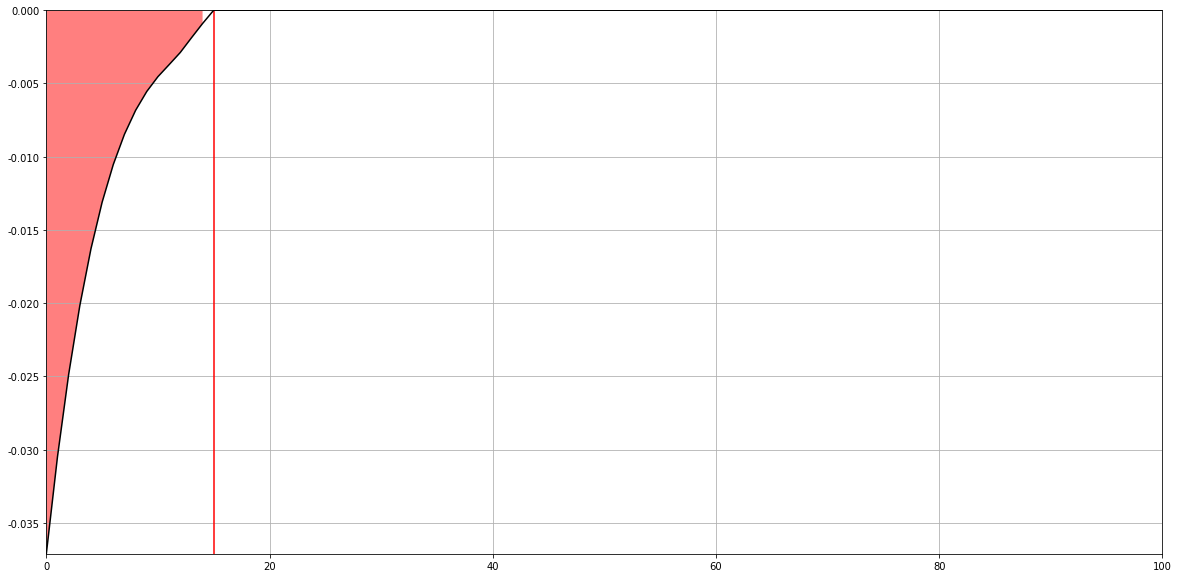

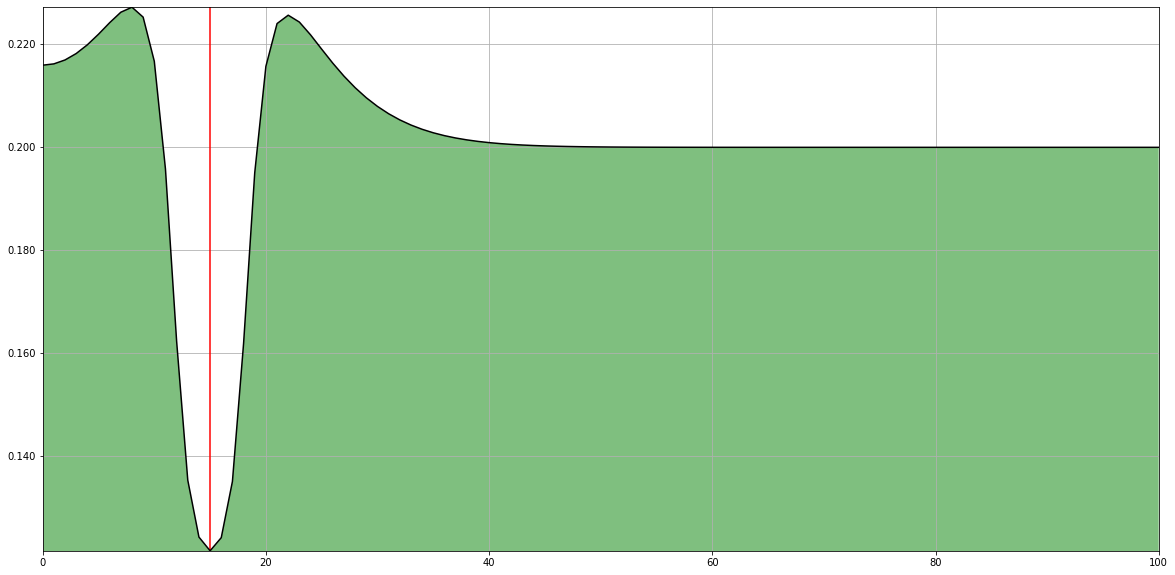

In [5]:
check_symmetry(add_point=0, func=Function(SUBSPACE.N, SUB_FUNC.N, 'neutral'))
